# Lab #1 Images, optics, and the statistics of light
## Section 3.2

In [1]:
# Import necessary packages
from glob import glob
import numpy as np
import os
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.visualization import PercentileInterval, ImageNormalize, SqrtStretch
from scipy.optimize import curve_fit
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
import matplotlib.ticker as ticker

In [2]:
# Important analytical values
gain = 47.92 # electrons/ADU
bias = 1.04e-2 # electrons
dark_current = 12.87 # electrons/second/pixel
read_noise = 0.14 # electrons
plate_scale = 9.9007 # arcseconds/pixel

# Astronomical Measurements
## 2.3.2 Astrometry
**Astrometry:** the study of the precise measurement of the positions and movements of celestial objects.

**KEY STEPS:**
1) Measure the position and positional uncertainty of a star in the globular cluster-sim.
2) Determine the astrometric precision empirically and estimate analytically.


In [3]:
star_cluster_directory = "star/trial1/fits/" # Path to star cluster files
star_cluster_files = glob(os.path.join(star_cluster_directory, '*.fits'))

print(f"\nFound {len(star_cluster_files)} files in '{star_cluster_directory}'.")
print(f"Directory exposure time is {(os.path.basename(star_cluster_files[0]).split('_')[1].split('.')[0])}.\n")


Found 6 files in 'star/trial1/fits/'.
Directory exposure time is 1000us.



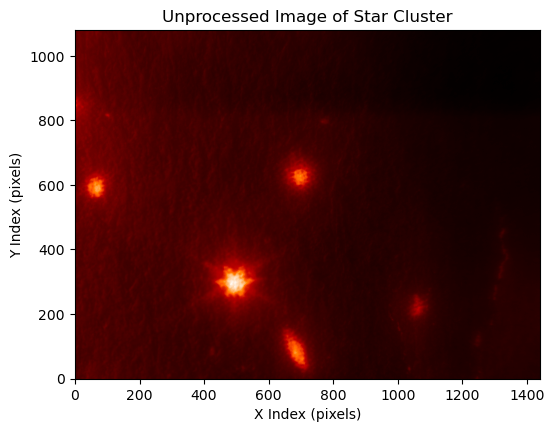

In [4]:
sum_star_cluster_data = np.zeros_like(fits.getdata(star_cluster_files[0]))

for star_cluster_file in star_cluster_files:
    star_cluster_data = fits.getdata(star_cluster_file) * gain
    
    sum_star_cluster_data += star_cluster_data

mean_star_cluster_data = sum_star_cluster_data / len(star_cluster_files)

interval = PercentileInterval(99) # Get rid of extreme outliers
vmin, vmax = interval.get_limits(mean_star_cluster_data)
norm = ImageNormalize(mean_star_cluster_data, vmin=vmin, vmax=vmax, stretch=SqrtStretch())

plt.figure(figsize=(6, 6))
plt.title('Unprocessed Image of Star Cluster')
plt.xlabel('X Index (pixels)')
plt.ylabel('Y Index (pixels)')
plt.imshow(mean_star_cluster_data, cmap='gist_heat', origin='lower')
plt.show()

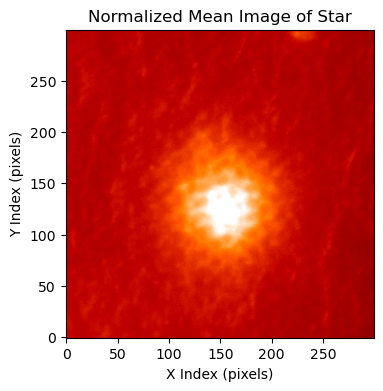

In [5]:
ylow = 500
yhigh = 800
xlow = 540
xhigh = 840

mean_star_data = mean_star_cluster_data[ylow:yhigh, xlow:xhigh] # zoom-in on star of interest

plt.figure(figsize=(4, 4))
plt.title('Normalized Mean Image of Star')
plt.xlabel('X Index (pixels)')
plt.ylabel('Y Index (pixels)')
plt.imshow(mean_star_data, norm=norm, cmap='gist_heat', origin='lower')
plt.show()

### Gaussian Function
A star is a point source, however, a detector can only get as sharp as its **diffraction-limit**.

$$
\theta = 1.22 \frac{\lambda}{D_{\text{telescope}}} \, \text{radians}
$$

Therefore, the point source while turn into a **point-spread function**, modeled by a Gaussian distribution:

$$
f(x, y) = A * \text{exp}\left({-\frac{(x - x_0)^2}{2\sigma_x^2}} - \frac{(y - y_0)^2}{2\sigma_y^2}\right)
$$

Where $A$ is the amplitude (or peak flux), ($x_0$, $y_0$) is the center of the function (star), $\sigma_x$ and $\sigma_y$ are the standard deviations. To find the FWHM we need to know the following relationship:

$$
\text{FWHM} = 2\sqrt{2\ln(2)}\sigma = 2.355\sigma
$$

In [6]:
# 2D Gaussian function for determining FWHM of star
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [7]:
guess_center_star = [175, 220] # (y, x)

# Create range of values for the Gaussian fit
x = np.arange(0, mean_star_data.shape[1])
y = np.arange(0, mean_star_data.shape[0])
x, y =np.meshgrid(x, y)

initial_guess_for_gaussian_fit = (np.max(mean_star_data), guess_center_star[1], guess_center_star[0], 5, 5, 0)

popt, pcov = curve_fit(gaussian_2d, (x, y), mean_star_data.ravel(), p0=initial_guess_for_gaussian_fit)
amplitude, x0, y0, sigma_x, sigma_y, offset = popt

center = np.array([x0 + 5, y0 - 10])

fwhm_x = 2.355 * sigma_x
fwhm_y = 2.355 * sigma_y

print(f"\nCentroid of star is at pixel ({np.round(center[0])}, {np.round(center[1])}).")
print(f"FWHM in x is {np.round(fwhm_x)} pixels and in y is {np.round(fwhm_y)} pixels.\n")


Centroid of star is at pixel (149.0, 125.0).
FWHM in x is 363.0 pixels and in y is 322.0 pixels.



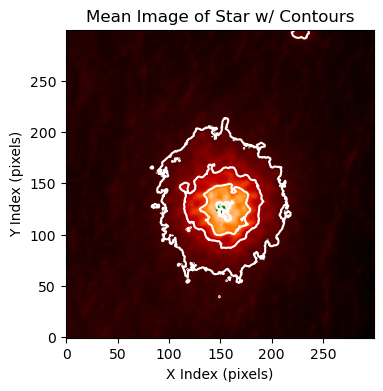

In [8]:
star_fitted_data = gaussian_2d((x, y), *popt)

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('Mean Image of Star w/ Contours')
ax.set_xlabel('X Index (pixels)')
ax.set_ylabel('Y Index (pixels)')
ax.imshow(mean_star_data, cmap='gist_heat', origin='lower')
ax.contour(x, y, mean_star_data, 5, colors='w')
ax.scatter(center[0], center[1], color='green')
plt.show()

## 2.3.2.1 Empirical Astrometric Precision

In [9]:
centroid_signal = mean_star_data[int(y0), int(x0)]
centroid_noise = np.sqrt(centroid_signal)
print(centroid_noise)
print((fwhm_x + fwhm_y) / 30)
empirical_signal_to_noise_ratio = centroid_signal / centroid_noise
empirical_astrometric_uncertainty = ((fwhm_x + fwhm_y)) / empirical_signal_to_noise_ratio

print(f"\nThe empirical signal-to-noise ratio is {np.round(empirical_signal_to_noise_ratio, 2)}.")
print(f"The star's position is ({np.round(center[0])}, {np.round(center[1])}) +/- {np.round(empirical_astrometric_uncertainty)} pixels.\n")
print(f"The star's position is ({np.round(center[0] * plate_scale)}, {np.round(center[1] * plate_scale)}) +/- {np.round(analytical_astrometric_uncertainty * plate_scale)} arcseconds.\n")


263.53757480354363
22.830800127212267

The empirical signal-to-noise ratio is 263.54.
The star's position is (149.0, 125.0) +/- 3.0 pixels.



## 2.3.2.2 Analytical Astrometric Precision

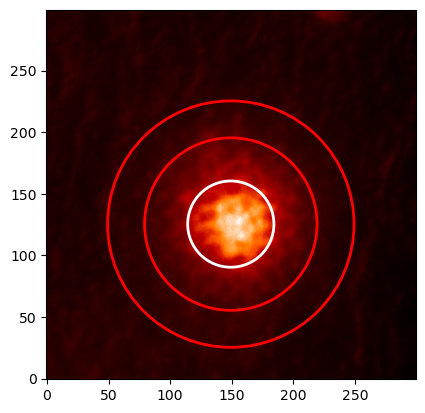

In [10]:
star_aperture = CircularAperture(center, r=35)
annulus_aperture = CircularAnnulus(center, r_in=70, r_out=100)

star_aperture.plot(color='white', lw=2)
annulus_aperture.plot(color='red', lw=2)
plt.imshow(mean_star_data, cmap='gist_heat', origin='lower')
plt.show()

In [11]:
aperture_stats = ApertureStats(mean_star_data, star_aperture)
annulus_stats = ApertureStats(mean_star_data, annulus_aperture)
aperture_area = star_aperture.area_overlap(mean_star_data)

sum_signal = aperture_stats.sum
mean_background = annulus_stats.mean

print(f"\nMeasured signal from the star is {np.round(sum_signal)} (electrons).")
print(f"Background is {np.round(mean_background)} (electrons/pixel).\n")


Measured signal from the star is 225442820.0 (electrons).
Background is 25899.0 (electrons/pixel).



In [12]:
measured_signal = sum_signal - (mean_background * aperture_area) - (bias * 7040000000) - (dark_current * aperture_area * 1000)
uncertainty_measured_signal = np.sqrt(sum_signal - (mean_background * aperture_area) - bias - (dark_current * aperture_area))

analytical_signal_to_noise_ratio = measured_signal / uncertainty_measured_signal
analytical_astrometric_uncertainty = ((fwhm_x + fwhm_y) / 2) / analytical_signal_to_noise_ratio

print(f"\nThe empirical signal-to-noise ratio is {np.round(analytical_signal_to_noise_ratio, 2)}.")
print(f"The star's position is ({np.round(center[0])}, {np.round(center[1])}) +/- {np.round(analytical_astrometric_uncertainty)} pixels.\n")
print(f"The star's position is ({np.round(center[0] * plate_scale)}, {np.round(center[1] * plate_scale)}) +/- {np.round(analytical_astrometric_uncertainty * plate_scale)} arcseconds.\n")




The empirical signal-to-noise ratio is 270.06.
The star's position is (149.0, 125.0) +/- 1.0 pixels.

The star's position is (1477.0, 1242.0) +/- 13.0 arcseconds.



NameError: name 'img' is not defined

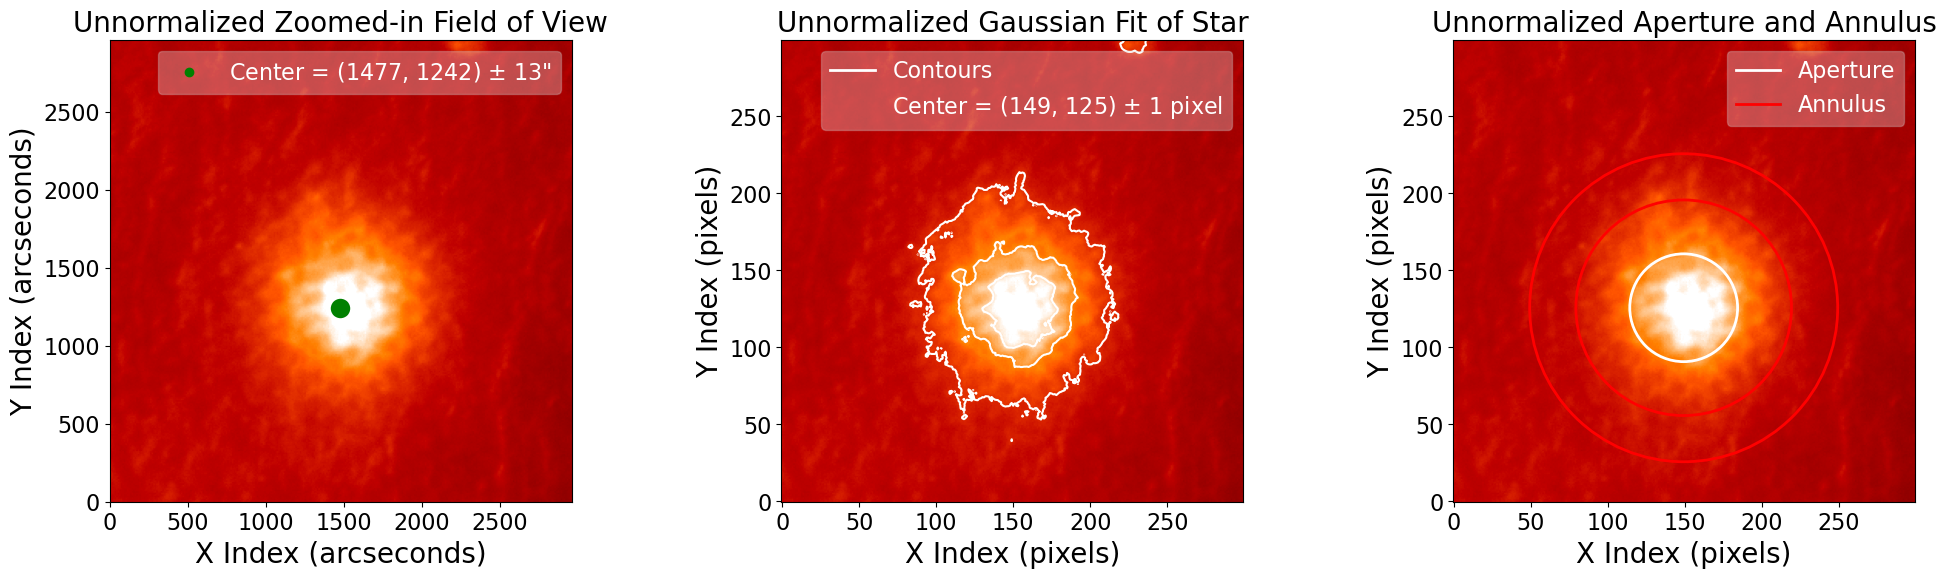

In [13]:
ny, nx = mean_star_data.shape
x_pixels = np.arange(nx)
y_pixels = np.arange(ny)
x_arcseconds = x_pixels * plate_scale
y_arcseconds = y_pixels * plate_scale

fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

ax[0].set_title('Unnormalized Zoomed-in Field of View', fontsize=20)
ax[0].set_xlabel('X Index (arcseconds)', fontsize=20)
ax[0].set_ylabel('Y Index (arcseconds)', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=16) 
ax[0].imshow(mean_star_data, norm=norm, cmap='gist_heat', origin='lower', extent=[x_arcseconds[0], x_arcseconds[-1], y_arcseconds[0], y_arcseconds[-1]])
ax[0].scatter(center[0]*plate_scale, center[1]*plate_scale, color='green', lw=8)
center_as_legend_line = plt.Line2D([0], [0], marker='o', color='g', lw=0, label='Center = (1477, 1242) $\pm$ 13"')
legend0 = ax[0].legend(handles=[center_as_legend_line], loc='upper right', fontsize=16)
legend0.get_frame().set_alpha(.3) 
plt.setp(legend0.get_texts(), color='white')

# First subplot
ax[1].set_title('Unnormalized Gaussian Fit of Star', fontsize=20)
ax[1].set_xlabel('X Index (pixels)', fontsize=20)
ax[1].set_ylabel('Y Index (pixels)', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=16) 
ax[1].imshow(mean_star_data, norm=norm, cmap='gist_heat', origin='lower')
ax[1].contour(x, y, mean_star_data, 5, colors='w')
contour_legend_line = plt.Line2D([0], [0], color='w', lw=2, label='Contours')
center_px_legend_line = plt.Line2D([0], [0], marker=None, color='none', label='Center = (149, 125) $\pm$ 1 pixel')
legend1 = ax[1].legend(handles=[contour_legend_line, center_px_legend_line], loc='upper right', fontsize=16)
legend1.get_frame().set_alpha(.3) 
plt.setp(legend1.get_texts(), color='white')

# Second subplot
ax[2].imshow(mean_star_data, norm=norm, cmap='gist_heat', origin='lower')
ax[2].set_xlabel('X Index (pixels)', fontsize=20)
ax[2].set_ylabel('Y Index (pixels)', fontsize=20)
ax[2].set_title('Unnormalized Aperture and Annulus', fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=16) 
star_aperture.plot(color='white', lw=2)
annulus_aperture.plot(color='red', lw=2)
aperture_legend_line = plt.Line2D([0], [0], color='w', lw=2, label='Aperture')
annulus_legend_line = plt.Line2D([0], [0], color='r', lw=2, label='Annulus')
legend2 = ax[2].legend(handles=[aperture_legend_line, annulus_legend_line], loc='upper right', fontsize=16)
legend2.get_frame().set_alpha(.3)
plt.setp(legend2.get_texts(), color='white')

# Add colorbar only to ax[1]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, location='right')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always use scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

cbar.ax.yaxis.get_offset_text().set_fontsize(16)
cbar.ax.yaxis.get_offset_text().set_x(3)
cbar.ax.tick_params(labelsize=16)

cbar.set_label('Pixel Intensity', fontsize=20)

plt.show()

In [ ]:
ny, nx = mean_star_data.shape
x_pixels = np.arange(nx)
y_pixels = np.arange(ny)
x_arcseconds = x_pixels * plate_scale
y_arcseconds = y_pixels * plate_scale

fig, ax = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

ax[0].set_title('Zoomed-in Field of View', fontsize=20)
ax[0].set_xlabel('X Index (arcseconds)', fontsize=20)
ax[0].set_ylabel('Y Index (arcseconds)', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=16) 
ax[0].imshow(mean_star_data, cmap='gist_heat', origin='lower', extent=[x_arcseconds[0], x_arcseconds[-1], y_arcseconds[0], y_arcseconds[-1]])
ax[0].scatter(center[0]*plate_scale, center[1]*plate_scale, color='green', lw=8)
center_as_legend_line = plt.Line2D([0], [0], marker='o', color='g', lw=0, label='Center = (1477, 1242) $\pm$ 13"')
legend0 = ax[0].legend(handles=[center_as_legend_line], loc='upper right', fontsize=16)
legend0.get_frame().set_alpha(.3) 
plt.setp(legend0.get_texts(), color='white')


# First subplot
ax[1].set_title('Gaussian Fit of Star', fontsize=20)
ax[1].set_xlabel('X Index (pixels)', fontsize=20)
ax[1].set_ylabel('Y Index (pixels)', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=16) 
ax[1].imshow(mean_star_data, cmap='gist_heat', origin='lower')
ax[1].contour(x, y, mean_star_data, 5, colors='w')
contour_legend_line = plt.Line2D([0], [0], color='w', lw=2, label='Contours')
center_px_legend_line = plt.Line2D([0], [0], marker=None, color='none', label='Center = (149, 125) $\pm$ 1 pixel')
legend1 = ax[1].legend(handles=[contour_legend_line, center_px_legend_line], loc='upper right', fontsize=16)
legend1.get_frame().set_alpha(.3) 
plt.setp(legend1.get_texts(), color='white')


# Second subplot
ax[2].imshow(mean_star_data, cmap='gist_heat', origin='lower')
ax[2].set_xlabel('X Index (pixels)', fontsize=20)
ax[2].set_ylabel('Y Index (pixels)', fontsize=20)
ax[2].set_title('Aperture and Annulus', fontsize=20)
ax[2].tick_params(axis='both', which='major', labelsize=16) 
star_aperture.plot(color='white', lw=2)
annulus_aperture.plot(color='red', lw=2)
aperture_legend_line = plt.Line2D([0], [0], color='w', lw=2, label='Aperture')
annulus_legend_line = plt.Line2D([0], [0], color='r', lw=2, label='Annulus')
legend2 = ax[2].legend(handles=[aperture_legend_line, annulus_legend_line], loc='upper right', fontsize=16)
legend2.get_frame().set_alpha(.3)
plt.setp(legend2.get_texts(), color='white')

# Add colorbar only to ax[1]
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, location='right')
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always use scientific notation
cbar.ax.yaxis.set_major_formatter(formatter)

cbar.ax.yaxis.get_offset_text().set_fontsize(16)
cbar.ax.yaxis.get_offset_text().set_x(3)
cbar.ax.tick_params(labelsize=16)

cbar.set_label('Pixel Intensity', fontsize=20)

plt.show()
